# Set-up
## Imports, load the dataset

In [401]:
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import numpy as np
import sklearn as skl
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import normalize
import tensorflow as tf
import os

# Load the diabetes dataset
diabetes = datasets.load_diabetes()
diabetes.DESCR

'Diabetes dataset\n================\n\nNotes\n-----\n\nTen baseline variables, age, sex, body mass index, average blood\npressure, and six blood serum measurements were obtained for each of n =\n442 diabetes patients, as well as the response of interest, a\nquantitative measure of disease progression one year after baseline.\n\nData Set Characteristics:\n\n  :Number of Instances: 442\n\n  :Number of Attributes: First 10 columns are numeric predictive values\n\n  :Target: Column 11 is a quantitative measure of disease progression one year after baseline\n\n  :Attributes:\n    :Age:\n    :Sex:\n    :Body mass index:\n    :Average blood pressure:\n    :S1:\n    :S2:\n    :S3:\n    :S4:\n    :S5:\n    :S6:\n\nNote: Each of these 10 feature variables have been mean centered and scaled by the standard deviation times `n_samples` (i.e. the sum of squares of each column totals 1).\n\nSource URL:\nhttp://www4.stat.ncsu.edu/~boos/var.select/diabetes.html\n\nFor more information see:\nBradley Efr

## Split the dataset into training and test

test size: 132


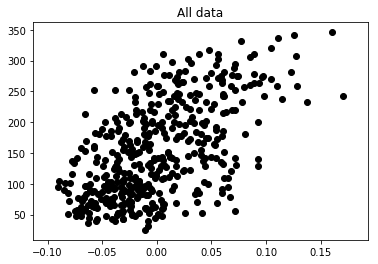

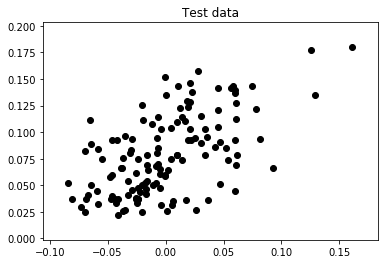

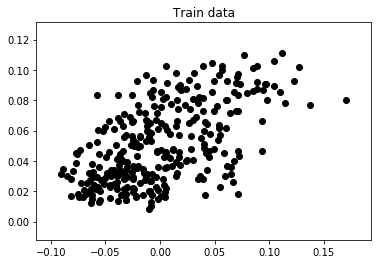

In [402]:
# Use only one feature
shuffle_ids = np.random.permutation(diabetes.data.shape[0])
diabetes_X = diabetes.data[shuffle_ids, np.newaxis, 2]
diabetes_y = diabetes.target[shuffle_ids]
test_size  = int(diabetes.data.shape[0] * 0.3)
print('test size: ' + str(test_size))

# Split the data into training/testing sets
diabetes_X_train = diabetes_X[:-test_size]
diabetes_X_test  = diabetes_X[-test_size:]

# Split the targets into training/testing sets
diabetes_y_train = normalize(diabetes_y[:-test_size, np.newaxis], axis=0)
diabetes_y_test  = normalize(diabetes_y[-test_size:, np.newaxis], axis=0)

# Plot data
plt.scatter(diabetes.data[:, np.newaxis, 2], diabetes.target,  color='black')
plt.title('All data')
plt.show()

plt.scatter(diabetes_X_test, diabetes_y_test,  color='black')
plt.title('Test data')
plt.show()

plt.scatter(diabetes_X_train, diabetes_y_train,  color='black')
plt.title('Train data')
plt.show()

## Model Space

In [403]:
# Create spaces of W and b
step    = 0.01
W_space = np.arange(-1, 2, step)
b_space = np.arange(-0.05 , 0.18, step/5)
costs   = np.zeros([len(b_space), len(W_space)])

# Compute the loss function for each
for i in range(len(b_space)):
    for j in range(len(W_space)):
        costs[i, j] = skl.metrics.mean_squared_error(diabetes_y_test, diabetes_X_test * W_space[j] + b_space[i])
        if i % 100 == 0 and j % 100 == 0:
            print('Computation for W ='
                  , "{:.4f}".format(W_space[j])
                  , '; b =', "{:.4f}".format(b_space[i])
                  , '; loss =', "{:.4f}".format(costs[i, j]))

print('Done')

Computation for W = -1.0000 ; b = -0.0500 ; loss = 0.0218
Computation for W = 0.0000 ; b = -0.0500 ; loss = 0.0179
Computation for W = 1.0000 ; b = -0.0500 ; loss = 0.0180
Computation for W = -1.0000 ; b = 0.1500 ; loss = 0.0105
Computation for W = 0.0000 ; b = 0.1500 ; loss = 0.0065
Computation for W = 1.0000 ; b = 0.1500 ; loss = 0.0065
Done


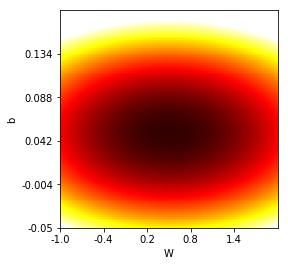

In [404]:
def loss_with_path(path, fig=plt):
    ticks_size = 5
    
    # Heatmap
    fig.imshow(costs, cmap='hot', norm = Normalize(vmin=0, vmax=0.015), interpolation='nearest', extent=[0, ticks_size, 0, ticks_size])
    fig.xlabel('W'); plt.xticks(range(ticks_size), W_space[np.arange(0, len(W_space), int(len(W_space) / ticks_size))])
    fig.ylabel('b'); plt.yticks(range(ticks_size), b_space[np.arange(0, len(b_space), int(len(b_space) / ticks_size))])
    
#     # Legend
#     fig.text(0.3, 4.3, 'min=' + "{:.4f}".format(np.min(costs)) + '\nmax=' + "{:.4f}".format(np.max(costs)), bbox={'facecolor': 'white', 'pad': 10})
    
    # Path
    path_x = path[:, 0]
    path_y = path[:, 1]
    
    map_space = lambda s: [np.min(s), ticks_size / (np.max(s) - np.min(s))]
    x_min, x_scale = map_space(W_space)
    y_min, y_scale = map_space(b_space)
    
    path_x_mapped = (path_x - x_min) * x_scale
    path_y_mapped = (path_y - y_min) * y_scale
        
    fig.plot(path_x_mapped, path_y_mapped, marker='o', label='Gradient Descent Path')
    fig.ylim([0,ticks_size])
    fig.xlim([0,ticks_size])

loss_with_path(np.array([[]]).reshape(0, 2))
plt.show()

# Training
## Define the linear regression model

In [405]:
# Parameters
learning_rate   = 0.1
n_samples       = diabetes_X_train.shape[0]

tf.reset_default_graph()

# tf Graph Input
X = tf.placeholder("float")
Y = tf.placeholder("float")

# Set model weights
W = tf.get_variable("weight", [1, 1], dtype=tf.float32, initializer=tf.glorot_uniform_initializer())
b = tf.get_variable("bias", [1], dtype=tf.float32, initializer=tf.glorot_uniform_initializer())

# Construct a linear model
pred = tf.add(tf.multiply(X, W), b)

# Mean squared error
cost = tf.losses.mean_squared_error(Y, pred)

# Summaries
tf.summary.scalar('loss', cost)
tf.summary.scalar('W', tf.reduce_max(W))
tf.summary.scalar('b', tf.reduce_max(b))
summaries = tf.summary.merge_all()

# Gradient descent
#  Note, minimize() knows to modify W and b because Variable objects are trainable=True by default
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

## Training

Epoch: 0000 cost= 0.006120700 W= [[ 1.119]] b= [ 0.1145]
Epoch: 0001 cost= 0.002279305 W= [[ 1.0195]] b= [ 0.025]
Epoch: 0002 cost= 0.008508172 W= [[ 0.9209]] b= [-0.0344]
Epoch: 0003 cost= 0.011820177 W= [[ 0.8238]] b= [-0.0533]
Epoch: 0004 cost= 0.009407082 W= [[ 0.7288]] b= [-0.0421]
Epoch: 0005 cost= 0.004726655 W= [[ 0.6365]] b= [-0.0131]
Epoch: 0006 cost= 0.001260962 W= [[ 0.5478]] b= [ 0.0243]
Epoch: 0007 cost= 0.000642744 W= [[ 0.4636]] b= [ 0.0622]
Epoch: 0008 cost= 0.002324441 W= [[ 0.3847]] b= [ 0.0936]
Epoch: 0009 cost= 0.004353344 W= [[ 0.3124]] b= [ 0.1129]
Epoch: 0010 cost= 0.005052107 W= [[ 0.2475]] b= [ 0.1182]
Epoch: 0011 cost= 0.004118521 W= [[ 0.1909]] b= [ 0.1107]
Epoch: 0012 cost= 0.002382269 W= [[ 0.1433]] b= [ 0.0936]
Epoch: 0013 cost= 0.000969785 W= [[ 0.1053]] b= [ 0.0709]
Epoch: 0014 cost= 0.000594194 W= [[ 0.0768]] b= [ 0.0468]
Epoch: 0015 cost= 0.001217240 W= [[ 0.0579]] b= [ 0.0257]
Epoch: 0016 cost= 0.002181252 W= [[ 0.0481]] b= [ 0.0109]
Epoch: 0017 cost

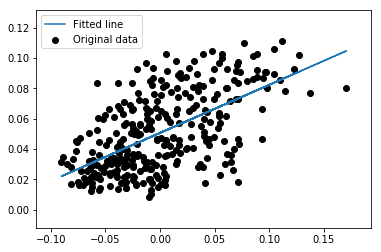

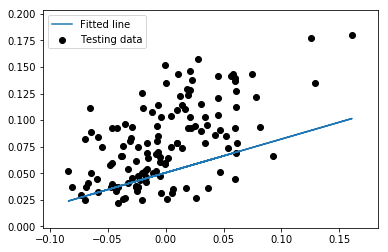

In [412]:
# Constants, create necessary dirs if they don't exist
training_epochs = 100
display_step    = 1
gradient_trace  = 10

log_dir_base  = './log'
plot_dir_base = './plot'

if not os.path.exists(plot_dir_base): os.makedirs(plot_dir_base)
if not os.path.exists(log_dir_base ): os.makedirs(log_dir_base)
    
log_dir  = log_dir_base + '/' + str(len(os.listdir(log_dir_base)))
plot_dir = plot_dir_base + '/' + str(len(os.listdir(plot_dir_base)))

if not os.path.exists(plot_dir): os.makedirs(plot_dir)

train_writer  = tf.summary.FileWriter(log_dir)

gradient_log = np.zeros([training_epochs, 2])

# Start training
with tf.Session() as sess:
    # Run the initializer
    sess.run(init)

    # Fit all training data
    for epoch in range(training_epochs):
        sess.run(optimizer, feed_dict={X: diabetes_X_train, Y: diabetes_y_train})
        
        # Display logs per epoch step
        if epoch % display_step == 0:
            # Write summaries for tensorboard
            sums, c, train_pred, W_res, b_res = sess.run([summaries, cost, pred, W, b], feed_dict={X: diabetes_X_train, Y: diabetes_y_train})
            train_writer.add_summary(sums, epoch)
            train_writer.flush()
            
            # Write gradient log
            gradient_log[epoch, 0] = W_res
            gradient_log[epoch, 1] = b_res
            
            # Plot the model and save to file            
            plt.subplot(2, 1, 1)
            plt.scatter(diabetes_X_train, diabetes_y_train, label='Original data', color='black')
            plt.plot(diabetes_X_train, train_pred, label='Fitted line')
            plt.ylim(0, 0.2)
            plt.title(str(epoch) + ': ' +
                      'W = ' + "{:.4f}".format(W_res[0, 0]) +
                      '; b = ' + "{:.4f}".format(b_res[0]) +
                      '; loss = ' + "{:.4f}".format(c))
            
            plt.subplot(2, 1, 2)
            loss_with_path(gradient_log[max(0,epoch-gradient_trace):epoch+1])

#             plt.subplots_adjust(wspace=0.5)
            plt.savefig(plot_dir + '/' + ('%04d' % epoch) + '.png')
            plt.clf()
            
            print("Epoch:", '%04d' % (epoch), "cost=", "{:.9f}".format(c), \
                "W=", W_res, "b=", b_res)

    print("Optimization Finished!")
    training_cost = sess.run(cost, feed_dict={X: diabetes_X_train, Y: diabetes_y_train})
    print("Training cost=", training_cost, "W=", sess.run(W), "b=", sess.run(b), '\n')

    # Graphic display
    diabetes_y_train_pred = sess.run(pred, feed_dict={X: diabetes_X_train})
    diabetes_y_test_pred  = sess.run(pred, feed_dict={X: diabetes_X_test })
    
    plt.scatter(diabetes_X_train, diabetes_y_train, label='Original data', color='black')
    plt.plot(diabetes_X_train, diabetes_y_train_pred, label='Fitted line')
    plt.legend()
    plt.show()

    plt.scatter(diabetes_X_test, diabetes_y_test, label='Testing data', color='black')
    plt.plot(diabetes_X_test, diabetes_y_test_pred, label='Fitted line')
    plt.legend()
    plt.show()


In [413]:
%%bash -s "$plot_dir"
echo "Creating video at $1"
cd $1
ffmpeg -r 15 -f image2 -i %04d.png -vcodec libx264 -crf 25 -pix_fmt yuv420p video.mp4

Creating video at ./plot/17


ffmpeg version 2.8.11-0ubuntu0.16.04.1 Copyright (c) 2000-2017 the FFmpeg developers
  built with gcc 5.4.0 (Ubuntu 5.4.0-6ubuntu1~16.04.4) 20160609
  configuration: --prefix=/usr --extra-version=0ubuntu0.16.04.1 --build-suffix=-ffmpeg --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --cc=cc --cxx=g++ --enable-gpl --enable-shared --disable-stripping --disable-decoder=libopenjpeg --disable-decoder=libschroedinger --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmodplug --enable-libmp3lame --enable-libopenjpeg --enable-libopus --enable-libpulse --enable-librtmp --enable-libschroedinger --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --e